# ImageNet Classification with Deep Convolutional Neural Networks
This notebook re-implements the paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Author:** Divyansh_Srivastava

### Setup notebook

In [6]:
# import necesaary libraries & packagaes
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

print("All necessary packages are imported successfully!")

All necessary packages are imported successfully!


### Setup Data

In [2]:
# Define image tranformation for data augmentation
tranform = transforms.Compose([
    transforms.Resize(256), # rescale the shorter side to 256
    transforms.RandomCrop(224), # randomly crop 224x224 part from images
    transforms.RandomHorizontalFlip(p=0.6), # randomly flip the image horizontaly with a probalibly og 0.6
    transforms.ToTensor() # to pytorch tensor
])

In [3]:
print(f'Started loading training data in memory....')
# load training data
train_dataset = datasets.ImageFolder(root='../input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train', transform=tranform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
print(f'Loaded training data in memory!')

Started loading training data in memory....
Loaded training data in memory!


### Set-up Model

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # Feature Extraction with Convolution 2D Layers
        self.features = nn.Sequential(
            # Conv Layer 1: (3, 224, 224) -> (96, 55, 55)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.00001, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            # Conv Layer 2: (96, 27, 27) -> (256, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            # Conv Layer 3: (256, 13, 13) -> (384, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        
            # Conv Layer 4: (384, 13, 13) -> (384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        
            # Conv Layer 5: (384, 13, 13) -> (256, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # (256, 6, 6)
        )
        
        # Classification with Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(inplace=True),
        
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
        
            nn.Linear(in_features=4096, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)  # extract features
        x = torch.flatten(x, 1)  # flatten features
        return self.classifier(x)  # return classification output
    
    def initialize_params(self):
        
        for partition in [self.features, self.classifier]:
            for i in range(len(partition)):
                try:
                    nn.init.normal_(partition[i].weight, mean=0.0, std=0.01)
                except:
                    break
        
        nn.init.constant_(self.features[4].bias, val=1)
        nn.init.constant_(self.features[9].bias, val=1)
        nn.init.constant_(self.features[11].bias, val=1)
        nn.init.constant_(self.classifier[1].bias, val=1)
        nn.init.constant_(self.classifier[4].bias, val=1)
        nn.init.constant_(self.classifier[6].bias, val=1)
        

## Training the model

Using cuda for training!
Using 2 GPUs!
Starting training epoch: 1:


Epoch [1/90]: 100%|██████████| 10010/10010 [1:23:40<00:00,  1.99it/s, loss=6.91]


Epoch [1/90], Average Loss: 6.9092


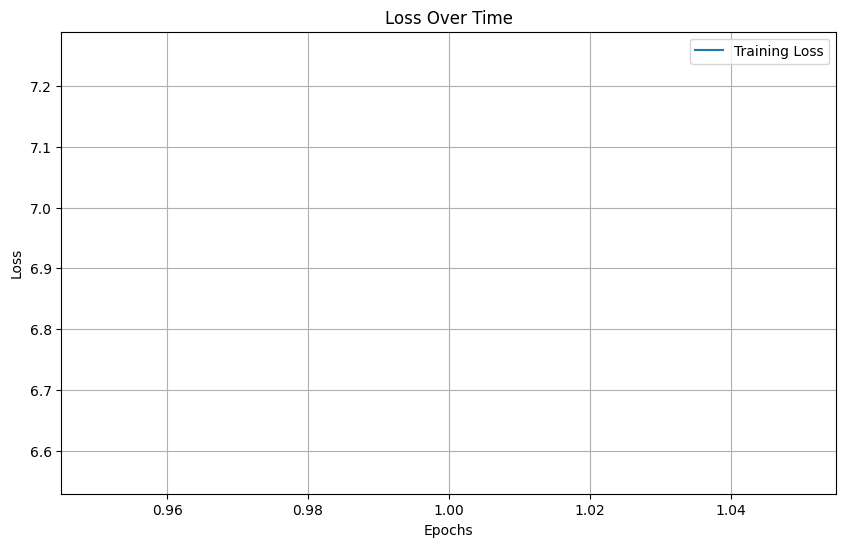

Starting training epoch: 2:


Epoch [2/90]:  66%|██████▋   | 6650/10010 [54:27<19:08,  2.93it/s, loss=6.91]  

In [ ]:
model = AlexNet()
model.initialize_params()

# define loss function
criterion = nn.CrossEntropyLoss()

#adam optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} for training!')

# If multiple GPUs are available, wrap the model in DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    
model.to(device)

# Training Loop
num_epochs = 90  # Set the number of epochs

# Initialize the list for storing epoch losses
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    print(f'Starting training epoch: {epoch+1}:')
    
    model.train()
    
    running_loss = 0.0
    
    # Progress bar for the current epoch
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch [{epoch+1}/{num_epochs}]')
    
    # Loop over batches
    for batch_idx, (image, label) in progress_bar:
        # Move inputs and targets to the GPU if available
        image, label_class = image.to(device, non_blocking=True), label.to(device, non_blocking=True)
        
        # Zero the gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass
        output_class = model(image)
        
        # Compute loss
        loss = criterion(output_class, label_class)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Track the running loss (sum of batch losses)
        running_loss += loss.item()
        
        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)  # Store the loss for plotting
    
    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')
    
    # Plot the loss curve after each epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()